## Brain Tumor Detection

[Dataset](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection)

# Import the necessary libraries

In [ ]:
import os
import cv2
import numpy as np
import pathlib
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.model_selection import train_test_split
import imutils

# Create the directory structure for augmented data
augmented_data_dir = 'augmented_data'
os.makedirs(augmented_data_dir, exist_ok=True)
yes_dir = os.path.join(augmented_data_dir, 'yes')
no_dir = os.path.join(augmented_data_dir, 'no')
os.makedirs(yes_dir, exist_ok=True)
os.makedirs(no_dir, exist_ok=True)

In [ ]:
# Original data paths
train_dir = '/content/drive/MyDrive/Data/brain_tumor_dataset'
train_dir = pathlib.Path(train_dir)
tumor_cells = list(train_dir.glob('yes/*'))
normal_cells = list(train_dir.glob('no/*'))

df_images = {
    'Tumor': tumor_cells,
    'Normal': normal_cells
}

df_labels = {
    'Tumor': 0,
    'Normal': 1
}

# ImageDataGenerator for Augmentation

* ImageDataGenerator: This is a class from the Keras library used to generate batches of tensor image data with real-time data augmentation.

* rotation_range=40: Randomly rotate images by up to 40 degrees.

* shear_range=0.2: Apply random shear transformations with a magnitude of 0.2.

* zoom_range=0.2: Apply random zooming within a range of 20% (either zoom in or out).

* horizontal_flip=True: Randomly flip images horizontally.

* brightness_range=(0.5, 1.5): Randomly change the brightness of images, ranging from 50% to 150%.

In [ ]:
# Data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.5, 1.5)
)


# Cropping Image

* Gaussian Blur:

    The grayscale image is blurred using a Gaussian filter with a kernel size of 3x3. Blurring helps in reducing noise and details, which is useful for more accurate thresholding and contour detection.

* Thresholding:

    The blurred grayscale image is thresholded using a binary threshold. This converts the image to a binary image where pixels are either 0 (black) or 255 (white). This step is crucial for contour detection.

* Noise Removal:

    The binary image undergoes erosion followed by dilation. Erosion removes small white noises, and dilation restores the shape of the object. This series of operations helps in cleaning up the binary image.

* Find Contours:

    Contours are detected in the binary image using cv2.findContours. Contours are the boundaries of objects in the image. The function then grabs the largest contour based on the area, assuming it to be the main object in the image.

* Find Extreme Points:

    The function finds the extreme points of the largest contour:


* Crop the Image:

    Using the extreme points, the function creates a rectangular crop of the original image. It uses these points to define the region of interest (ROI) and extracts this part from the image.

In [ ]:
def crop_img(img):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    # Check if the image is grayscale, and convert it to RGB if needed
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # Threshold the image, then perform a series of erosions and dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

    return new_img


# Function to save augmented images

In [ ]:
def save_augmented_images(label, images, save_dir, augment_size=7):
    for image_path in images:
        img = load_img(image_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Generate augmented images and save them
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=save_dir, save_prefix=label, save_format='jpg'):
            i += 1
            if i >= augment_size:
                break


In [ ]:
# Apply augmentation and save images
save_augmented_images('Tumor', tumor_cells, yes_dir, augment_size=7)
save_augmented_images('Normal', normal_cells, no_dir, augment_size=7)

# Load original and augmented images

In [ ]:
def load_images_and_labels(df_images, df_labels, augmented_data_dir):
    X, y = [], [] # X = images, y = labels

    # Load original images
    for label, images in df_images.items():
        for image in images:
            img = cv2.imread(str(image))
            new_img = crop_img(img)
            resized_img = cv2.resize(new_img, (224, 224)) # Resizing the images
            X.append(resized_img)
            y.append(df_labels[label])

    # Load augmented images
    for label, folder in zip(['Tumor', 'Normal'], ['yes', 'no']):
        augmented_images_dir = os.path.join(augmented_data_dir, folder)
        augmented_images = list(pathlib.Path(augmented_images_dir).glob('*.jpg'))
        for image in augmented_images:
            img = cv2.imread(str(image))
            cropped_img = crop_img(img)
            resized_img = cv2.resize(cropped_img, (224, 224))  # Resizing the images
            X.append(resized_img)
            y.append(df_labels[label])

    return np.array(X), np.array(y)


# Load images and labels

In [ ]:
X, y = load_images_and_labels(df_images, df_labels, augmented_data_dir)

In [ ]:
import numpy as np

np.unique(y)

array([0, 1])

In [ ]:
print(len(X))

1939


# Standardizing

In [ ]:
X = X / 255.0

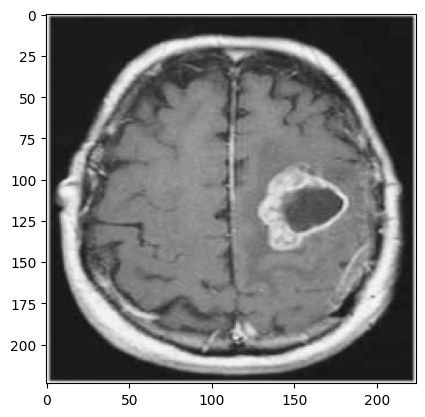

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X[0])

# Train Test Splitting

In [ ]:
from sklearn.model_selection import train_test_split

# Initial split into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)


Training set size: (1163, 224, 224, 3)
Validation set size: (388, 224, 224, 3)
Test set size: (388, 224, 224, 3)


# Sequential Model with VGG16 Base

# VGG16


In [ ]:
import tensorflow
from tensorflow.keras import models,layers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load pre-trained VGG16 model without including the top (classification) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Freeze the layers in the base model (optional)
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Create a new model on top of the VGG16 base
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 6

In [ ]:
# Fit the model with validation data
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/10
37/37 [==============================] - 33s 465ms/step - loss: 0.9206 - accuracy: 0.6197 - val_loss: 0.4034 - val_accuracy: 0.8107
Epoch 2/10
37/37 [==============================] - 6s 171ms/step - loss: 0.5301 - accuracy: 0.7521 - val_loss: 0.3156 - val_accuracy: 0.8440
Epoch 3/10
37/37 [==============================] - 6s 171ms/step - loss: 0.3040 - accuracy: 0.8632 - val_loss: 0.1948 - val_accuracy: 0.9309
Epoch 4/10
37/37 [==============================] - 7s 199ms/step - loss: 0.2044 - accuracy: 0.9145 - val_loss: 0.1847 - val_accuracy: 0.9156
Epoch 5/10
37/37 [==============================] - 6s 173ms/step - loss: 0.1481 - accuracy: 0.9385 - val_loss: 0.1882 - val_accuracy: 0.9130
Epoch 6/10
37/37 [==============================] - 7s 202ms/step - loss: 0.0759 - accuracy: 0.9709 - val_loss: 0.1291 - val_accuracy: 0.9437
Epoch 7/10
37/37 [==============================] - 7s 202ms/step - loss: 0.0646 - accuracy: 0.9752 - val_loss: 0.1010 - val_accuracy: 0.9693
Epoch

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

13/13 [==============================] - 2s 123ms/step - loss: 0.3182 - accuracy: 0.9258
Test Loss: 0.31822988390922546
Test Accuracy: 0.9258311986923218


In [ ]:
# Load and preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    cropped_img = crop_img(img)
    resized_img = cv2.resize(cropped_img, (224, 224))
    normalized_img = resized_img / 255.0  # Normalize to [0, 1] range
    return normalized_img

# Function to classify the image
def classify_image(image_path):
    preprocessed_img = preprocess_image(image_path)
    input_img = np.expand_dims(preprocessed_img, axis=0)  # Add batch dimension
    prediction = model.predict(input_img)
    if prediction[0] < 0.5:
        print(prediction)
        return 'tumor'
    else:
        print(prediction)
        return 'normal'

In [ ]:
img3 = '/content/Y10.jpg'
result = classify_image(img3)
print(f"The image is classified as: {result}")

1/1 [==============================] - 0s 22ms/step
[[0.0001875]]
The image is classified as: tumor


In [ ]:
img1 = '/content/y703.jpg'
result = classify_image(img1)
print(f"The image is classified as: {result}")

1/1 [==============================] - 1s 1s/step
[[0.97614187]]
The image is classified as: normal


In [ ]:
img2 ='/content/Te-no_0017.jpg'
result = classify_image(img2)
print(f"The image is classified as: {result}")

1/1 [==============================] - 0s 18ms/step
[[0.64541507]]
The image is classified as: normal


In [ ]:
img3 ='/content/Te-no_0015.jpg'
result = classify_image(img3)
print(f"The image is classified as: {result}")

1/1 [==============================] - 0s 27ms/step
[[0.00210878]]
The image is classified as: normal


# Sequential Model with ResNet50 Base

# ResNet

In [ ]:
from keras.applications.resnet import ResNet50

resmodel= ResNet50(weights='imagenet', include_top=False, input_shape = (224,224,3))

base_model_2 = resmodel

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Freeze the layers in the base model (optional)
for layer in base_model_2.layers:
    layer.trainable = False

# Create a new model on top of the VGG16 base
model2 = Sequential()
model2.add(base_model_2)
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(128,activation='relu'))
model2.add(Dense(64,activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 512)               51380736  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                

In [ ]:
# Fit the model with validation data
history = model2.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

In [ ]:
# Evaluate the model on the test set
test_loss2, test_accuracy2 = model2.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss2}")
print(f"Test Accuracy: {test_accuracy2}")

13/13 [==============================] - 2s 93ms/step - loss: 0.7198 - accuracy: 0.4846
Test Loss: 0.7198423743247986
Test Accuracy: 0.48461538553237915


# CNN

In [ ]:
model3 = Sequential()
model3.add(Conv2D(filters=16, kernel_size=(3, 3), activation="relu", kernel_initializer="he_uniform", padding="same", input_shape=(224, 224, 3)))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_uniform", padding="same"))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", kernel_initializer="he_uniform", padding="same"))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Flatten())
model3.add(Dense(units=128, activation="relu", kernel_initializer="he_uniform"))
model3.add(Dense(units=1, activation="sigmoid"))

# compile the model
model3.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 64)        0

In [ ]:
# Fit the model with validation data
history3 = model3.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/10
37/37 [==============================] - 10s 79ms/step - loss: 3.8005 - accuracy: 0.5584 - val_loss: 0.6726 - val_accuracy: 0.6041
Epoch 2/10
37/37 [==============================] - 1s 35ms/step - loss: 0.6418 - accuracy: 0.6186 - val_loss: 0.6250 - val_accuracy: 0.6658
Epoch 3/10
37/37 [==============================] - 1s 36ms/step - loss: 0.5317 - accuracy: 0.7509 - val_loss: 0.5799 - val_accuracy: 0.6967
Epoch 4/10
37/37 [==============================] - 1s 35ms/step - loss: 0.3874 - accuracy: 0.8445 - val_loss: 0.4829 - val_accuracy: 0.7609
Epoch 5/10
37/37 [==============================] - 2s 42ms/step - loss: 0.3028 - accuracy: 0.8746 - val_loss: 0.4828 - val_accuracy: 0.7738
Epoch 6/10
37/37 [==============================] - 2s 45ms/step - loss: 0.2254 - accuracy: 0.9098 - val_loss: 0.4812 - val_accuracy: 0.7943
Epoch 7/10
37/37 [==============================] - 2s 41ms/step - loss: 0.1666 - accuracy: 0.9416 - val_loss: 0.4436 - val_accuracy: 0.7995
Epoch 8/10
3

In [ ]:
# Evaluate the model on the test set
test_loss3, test_accuracy3 = model3.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss3}")
print(f"Test Accuracy: {test_accuracy3}")

13/13 [==============================] - 0s 17ms/step - loss: 0.5911 - accuracy: 0.8406
Test Loss: 0.5911273956298828
Test Accuracy: 0.8406169414520264


In [ ]:
# Load and preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    cropped_img = crop_img(img)
    resized_img = cv2.resize(cropped_img, (224, 224))
    normalized_img = resized_img / 255.0  # Normalize to [0, 1] range
    return normalized_img



In [ ]:
# Function to classify the image
def classify_image(image_path):
    preprocessed_img = preprocess_image(image_path)
    input_img = np.expand_dims(preprocessed_img, axis=0)  # Add batch dimension
    prediction = model3.predict(input_img)
    if prediction[0] < 0.5:
        print(prediction)
        return 'tumor'
    else:
        print(prediction)
        return 'normal'

In [ ]:
img1 = '/content/y703.jpg'
result = classify_image(img1)
print(f"The image is classified as: {result}")

1/1 [==============================] - 0s 17ms/step
[[0.9419334]]
The image is classified as: tumor


In [ ]:
img2 ='/content/Te-no_0017.jpg'
result = classify_image(img2)
print(f"The image is classified as: {result}")

1/1 [==============================] - 0s 17ms/step
[[0.5652458]]
The image is classified as: tumor


# Sequential Model with MobileNet Base

# MobileNet

In [ ]:
from keras.applications.mobilenet import MobileNet

# Load the MobileNet model
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))

base_model_4 = mobilenet

17225924/17225924 [==============================] - 1s 0us/step


In [ ]:
# Freeze the layers in the base model (optional)
for layer in base_model_4.layers:
    layer.trainable = False

# Create a new model on top of the MobileNet base
model4 = Sequential()
model4.add(base_model_4)
model4.add(Flatten())
model4.add(Dense(512, activation='relu'))
model4.add(Dropout(0.3))
model4.add(Dense(128,activation='relu'))
model4.add(Dense(64,activation='relu'))
model4.add(Dense(1, activation='sigmoid'))

# Compile the model
model4.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model4.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 512)               25690624  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                        

In [ ]:
# Fit the model with validation data
history = model4.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/10
37/37 [==============================] - 15s 170ms/step - loss: 3.4379 - accuracy: 0.6913 - val_loss: 0.2612 - val_accuracy: 0.9304
Epoch 2/10
37/37 [==============================] - 2s 65ms/step - loss: 0.3751 - accuracy: 0.9054 - val_loss: 0.2187 - val_accuracy: 0.9510
Epoch 3/10
37/37 [==============================] - 2s 66ms/step - loss: 0.1689 - accuracy: 0.9458 - val_loss: 0.1209 - val_accuracy: 0.9588
Epoch 4/10
37/37 [==============================] - 2s 65ms/step - loss: 0.0807 - accuracy: 0.9776 - val_loss: 0.1125 - val_accuracy: 0.9742
Epoch 5/10
37/37 [==============================] - 3s 69ms/step - loss: 0.0161 - accuracy: 0.9948 - val_loss: 0.1284 - val_accuracy: 0.9665
Epoch 6/10
37/37 [==============================] - 3s 70ms/step - loss: 0.0298 - accuracy: 0.9897 - val_loss: 0.0784 - val_accuracy: 0.9794
Epoch 7/10
37/37 [==============================] - 2s 63ms/step - loss: 0.0057 - accuracy: 0.9974 - val_loss: 0.0770 - val_accuracy: 0.9820
Epoch 8/10


In [ ]:
# Evaluate the model on the test set
test_loss4, test_accuracy4 = model4.evaluate(X_test, y_test)

13/13 [==============================] - 1s 42ms/step - loss: 0.0893 - accuracy: 0.9665


In [ ]:
print(f"Test Loss: {test_loss4}")
print(f"Test Accuracy: {test_accuracy4}")

Test Loss: 0.08932127058506012
Test Accuracy: 0.9664948582649231


In [ ]:
# Save the model to a file
model4.save("mobilenet_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load and preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    cropped_img = crop_img(img)
    resized_img = cv2.resize(cropped_img, (224, 224))
    normalized_img = resized_img / 255.0  # Normalize to [0, 1] range
    return normalized_img

# Function to classify the image
def classify_image(image_path):
    preprocessed_img = preprocess_image(image_path)
    input_img = np.expand_dims(preprocessed_img, axis=0)  # Add batch dimension
    prediction = model4.predict(input_img)
    if prediction[0] < 0.5:
        print(prediction)
        return 'tumor'
    else:
        print(prediction)
        return 'normal'


In [ ]:
img1 = '/content/Y1.jpg'
result = classify_image(img1)
print(f"The image is classified as: {result}")

1/1 [==============================] - 1s 938ms/step
[[2.5784414e-12]]
The image is classified as: tumor


In [ ]:
img2 ='/content/Te-no_0017.jpg'
result = classify_image(img2)
print(f"The image is classified as: {result}")

1/1 [==============================] - 0s 45ms/step
[[0.58457893]]
The image is classified as: normal


# Sequential Model with DenseNet Base

# DenseNet

In [ ]:
from keras.applications.densenet import DenseNet121

densmodel= DenseNet121(weights='imagenet', include_top=False, input_shape = (224,224,3))

base_model_5 = densmodel

In [ ]:
# Freeze the layers in the base model (optional)
for layer in base_model_5.layers:
    layer.trainable = False

# Create a new model on top of the DenseNet base
model5 = Sequential()
model5.add(base_model_5)
model5.add(Flatten())
model5.add(Dense(512, activation='relu'))
model5.add(Dropout(0.3))
model5.add(Dense(128,activation='relu'))
model5.add(Dense(64,activation='relu'))
model5.add(Dense(1, activation='sigmoid'))

# Compile the model
model5.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               25690624  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                

In [ ]:
# Fit the model with validation data
history = model5.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)


Epoch 1/10
37/37 [==============================] - 26s 376ms/step - loss: 2.7364 - accuracy: 0.6573 - val_loss: 0.5016 - val_accuracy: 0.8159
Epoch 2/10
37/37 [==============================] - 5s 130ms/step - loss: 0.6588 - accuracy: 0.8231 - val_loss: 0.2265 - val_accuracy: 0.9156
Epoch 3/10
37/37 [==============================] - 5s 128ms/step - loss: 0.2303 - accuracy: 0.9222 - val_loss: 0.1348 - val_accuracy: 0.9412
Epoch 4/10
37/37 [==============================] - 5s 135ms/step - loss: 0.1340 - accuracy: 0.9487 - val_loss: 0.2075 - val_accuracy: 0.9258
Epoch 5/10
37/37 [==============================] - 5s 128ms/step - loss: 0.0940 - accuracy: 0.9615 - val_loss: 0.1035 - val_accuracy: 0.9642
Epoch 6/10
37/37 [==============================] - 5s 129ms/step - loss: 0.0460 - accuracy: 0.9855 - val_loss: 0.0796 - val_accuracy: 0.9693
Epoch 7/10
37/37 [==============================] - 5s 139ms/step - loss: 0.0173 - accuracy: 0.9957 - val_loss: 0.0964 - val_accuracy: 0.9668
Epoch

In [ ]:
# Evaluate the model on the test set
test_loss5, test_accuracy5 = model5.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss5}")
print(f"Test Accuracy: {test_accuracy5}")

13/13 [==============================] - 1s 95ms/step - loss: 0.1433 - accuracy: 0.9591
Test Loss: 0.14332927763462067
Test Accuracy: 0.9590792655944824


In [ ]:
# Load and preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    cropped_img = crop_img(img)
    resized_img = cv2.resize(cropped_img, (224, 224))
    normalized_img = resized_img / 255.0  # Normalize to [0, 1] range
    return normalized_img

# Function to classify the image
def classify_image(image_path):
    preprocessed_img = preprocess_image(image_path)
    input_img = np.expand_dims(preprocessed_img, axis=0)  # Add batch dimension
    prediction = model5.predict(input_img)
    if prediction[0] < 0.5:
        print(prediction)
        return 'tumor'
    else:
        print(prediction)
        return 'normal'

In [ ]:
img1 = '/content/Y1.jpg'
result = classify_image(img1)
print(f"The image is classified as: {result}")

1/1 [==============================] - 4s 4s/step
[[5.293991e-07]]
The image is classified as: tumor


In [ ]:
img2 ='/content/Te-no_0017.jpg'
result = classify_image(img2)
print(f"The image is classified as: {result}")

1/1 [==============================] - 0s 34ms/step
[[0.97611517]]
The image is classified as: normal
